# Gradient Monte Carlo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

## Update rule
The update rule for gradient-monte-carlo is
$$
\begin{align}
    w_{t+1} = w_t + \alpha\big(G_t - w_t^\top x(S_t)\big)x(S_t)
\end{align}
$$

In [2]:
class RandomWalk(gym.Env):
    def __init__(self, states:int):
        super(RandomWalk, self).__init__()

        self.states = states
        self.current_state = None

        self.observation_space = gym.spaces.Box(low=0, high=states, shape=(1,), dtype=np.int32)
        self.action_space = gym.spaces.Discrete(2)

        self.action_translation = [-1, 1]

    def reset(self, seed:int=None):
        self.current_state = self.states // 2
        return {'state':self.current_state}

    def is_terminated(self):
        return self.current_state in [0, self.states - 1]

    def step(self, action:int):
        if action >= len(self.action_translation):
            raise ValueError("Action is undefined!")

        if self.current_state is None:
            raise ValueError("Please reset the environment first")

        if self.is_terminated():
            return {'state': self.current_state, 'reward': 0, 'terminated':True}

        self.current_state += self.action_translation[action] * np.random.randint(1, 101)
        self.current_state = np.clip(self.current_state, 0, self.states - 1)

        reward = 0
        if self.is_terminated():
            reward = 1 if self.current_state == self.states - 1 else -1
        return {'state': self.current_state, 'reward': reward, 'terminated':self.is_terminated()}

In [3]:
def generate_trajectory(env: RandomWalk, policy):
    obs = env.reset()
    trajectory = [obs]
    while not env.is_terminated():
        state = obs['state']
        action = policy(state)
        obs = env.step(action)
        trajectory.append(obs)
    return trajectory

In [4]:
def policy(state:int):
    return np.random.choice([0, 1])

In [5]:
def gradient_monte_carlo(
    *,
    policy,
    groups:int,
    episodes:int,
    alpha:float,
    gamma:float,
    env:RandomWalk
):
    w = np.zeros((groups,), dtype=np.float32)
    states = env.states
    per_group = states // groups
    visits = np.zeros(states, dtype=np.float32)

    for episode in range(episodes):
        trajectory = generate_trajectory(env, policy)
        gt = 0
        for i in reversed(range(len(trajectory) - 1)):
            state = trajectory[i]['state']
            visits[state] += 1
            gt = gamma * gt + trajectory[i + 1]['reward']

            grad_w = np.zeros(groups, dtype=np.float32)
            grad_w[state // per_group] = 1
            w = w + alpha * (gt - w) * grad_w
        if episode % 1000 == 0:
            print(f'\rEpisode {episode:>6}', end='')
    print()

    return w, visits

In [8]:
env = RandomWalk(1000)
episodes = 100_000
w, visits = gradient_monte_carlo(
    policy=policy, 
    groups=10, 
    episodes=episodes, 
    alpha=2e-5, 
    gamma=1.0, 
    env=env
)

Episode  99000


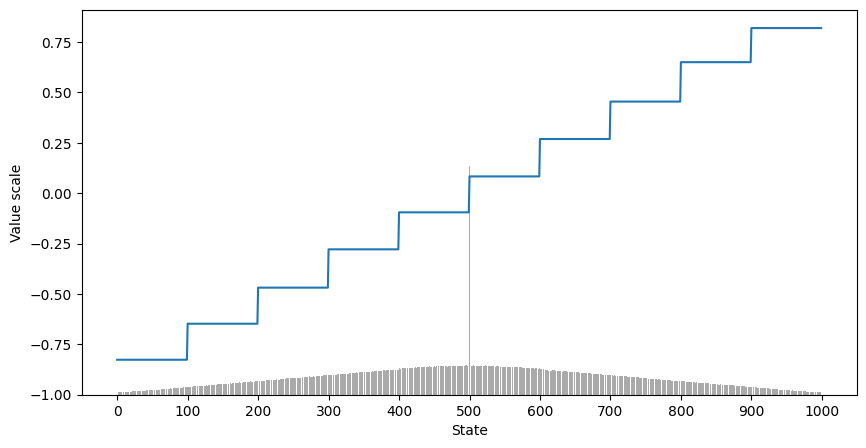

In [9]:
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot()
ax.plot(np.arange(0, 1000), w[np.arange(0, 1000) // 100])
ax.bar(range(visits.shape[0]), (visits / episodes), color='#aaa', bottom=-1)
ax.set_xticks(range(0, 1001, 100));
ax.set_xlabel("State")
ax.set_ylabel("Value scale");